In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#tutorial followed 
#https://towardsdatascience.com/energy-consumption-time-series-forecasting-with-python-and-lstm-deep-learning-model-7952e2f9a796

In [8]:
import pandas as pd
pd.__version__

'1.1.2'

In [9]:
import sys
print(sys.executable)

/home/ubuntu/anaconda3/envs/evgeny/bin/python


In [10]:
holidata = pd.read_csv('./dataB1_weather&holidays_nogaps.csv', index_col=0)
holidata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177792 entries, 2014-12-06 00:00:00 to 2019-12-31 23:45:00
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Valeur             177792 non-null  float64
 1   working day        177792 non-null  bool   
 2   Temperatures (°C)  177792 non-null  float64
 3   Radiation (Wh/m²)  177792 non-null  float64
 4   Wind speed (m/s)   177792 non-null  float64
 5   hour of day        177792 non-null  int64  
 6   day of week        177792 non-null  int64  
 7   month              177792 non-null  int64  
 8   minutes            177792 non-null  int64  
 9   hour of day_sin    177792 non-null  float64
 10  hour of day_cos    177792 non-null  float64
 11  day of week_sin    177792 non-null  float64
 12  day of week_cos    177792 non-null  float64
 13  month_sin          177792 non-null  float64
 14  month_cos          177792 non-null  float64
 15  minutes_sin        177792

In [11]:
holidata.columns

Index(['Valeur', 'working day', 'Temperatures (°C)', 'Radiation (Wh/m²)',
       'Wind speed (m/s)', 'hour of day', 'day of week', 'month', 'minutes',
       'hour of day_sin', 'hour of day_cos', 'day of week_sin',
       'day of week_cos', 'month_sin', 'month_cos', 'minutes_sin',
       'minutes_cos'],
      dtype='object')

In [12]:
holidata['Datetime'] = pd.to_datetime(holidata.index)
holidata = holidata.drop_duplicates(subset=['Datetime'])
holidata = holidata.sort_index()
holidata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177792 entries, 2014-12-06 00:00:00 to 2019-12-31 23:45:00
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Valeur             177792 non-null  float64       
 1   working day        177792 non-null  bool          
 2   Temperatures (°C)  177792 non-null  float64       
 3   Radiation (Wh/m²)  177792 non-null  float64       
 4   Wind speed (m/s)   177792 non-null  float64       
 5   hour of day        177792 non-null  int64         
 6   day of week        177792 non-null  int64         
 7   month              177792 non-null  int64         
 8   minutes            177792 non-null  int64         
 9   hour of day_sin    177792 non-null  float64       
 10  hour of day_cos    177792 non-null  float64       
 11  day of week_sin    177792 non-null  float64       
 12  day of week_cos    177792 non-null  float64       
 13  month_sin         

In [111]:
# Deep learning: 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
import itertools

class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        temp_var: str,
        rad_var: str,
        wind_var: str,
        holi_var: str,
        time_var: str,
        hour_var_sin: str,
        hour_var_cos: str,
        day_week_sin: str,
        day_week_cos: str,
        month_sin: str,
        month_cos: str,
        minutes_sin: str,
        minutes_cos: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.temp_var = temp_var
        self.rad_var = rad_var
        self.wind_var = wind_var
        self.holi_var = holi_var
        self.time_var = time_var
        self.hour_var_sin = hour_var_sin
        self.hour_var_cos = hour_var_cos
        self.day_week_sin = day_week_sin
        self.day_week_cos = day_week_cos
        self.month_sin = month_sin
        self.month_cos = month_cos
        self.minutes_sin = minutes_sin
        self.minutes_cos = minutes_cos
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, datetime: list, holiday: list, temperature: list, irradiance: list, wind: list, hour_cos: list, hour_sin: list, week_cos: list, week_sin: list, month_cos: list, month_sin: list, minute_cos: list, minute_sin: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []
        

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                # Substacted 96 for not knowing the day before
                ab = list(itertools.chain([ts[i+lag - 96]], [ts[i+lag - 672]], [holiday[i + lag]], [temperature[i + lag]], [irradiance[i + lag]], [wind[i + lag]], [hour_cos[i + lag]], [hour_sin[i + lag]], [week_cos[i + lag]], [week_sin[i + lag]], [month_cos[i + lag]], [month_sin[i + lag]], [minute_cos[i + lag]], [minute_sin[i + lag]]))
                X.append(ab)
                #X.append(ts[i:(i + lag - 96)] + [holiday[i + lag]] + [hour_cos[i + lag]] + [hour_sin[i + lag]] + )
                #X.append(datetime[i + lag])
                #X.append(holiday[i + lag])
                #X.append(hour_cos[i + lag])
                #X.append(hour_sin[i + lag])
                #X.append(week_cos[i + lag])
                #X.append(week_sin[i + lag])
                #X.append(month_cos[i + lag])
                #X.append(month_sin[i + lag])
      
        
        """
        for i in range(len(ts)):
            Y.append(ts[i])
            X.append(datetime[i])
            X.append(holiday[i])
            X.append(hour_cos[i])
            X.append(hour_sin[i])
            X.append(week_cos[i])
            X.append(week_sin[i])
            X.append(month_cos[i])
            X.append(month_sin[i]) 
        """
        
        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()
        y_datetime = self.data[self.time_var].tolist()
        y_holiday = self.data[self.holi_var].tolist()
        y_temp = self.data[self.temp_var].tolist()
        y_rad = self.data[self.rad_var].tolist()
        y_wind = self.data[self.wind_var].tolist()
        y_hour_cos = self.data[self.hour_var_cos].tolist()
        y_hour_sin = self.data[self.hour_var_sin].tolist()
        y_weekday_cos = self.data[self.day_week_cos].tolist()
        y_weekday_sin = self.data[self.day_week_sin].tolist()
        y_month_cos = self.data[self.month_cos].tolist()
        y_month_sin = self.data[self.month_sin].tolist()
        y_minute_cos = self.data[self.minutes_cos].tolist()
        y_minute_sin = self.data[self.minutes_sin].tolist()
        



        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, y_datetime, y_holiday, y_temp, y_rad, y_wind, y_hour_cos, y_hour_sin, y_weekday_cos, y_weekday_sin, y_month_cos, y_month_sin, y_minute_cos, y_minute_sin, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]
        print(X_train.shape)
        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()
        print(X_train.shape)
        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        # Setting up early stopping
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
        
        # Saving training history
        csv_logger = CSVLogger('training_B2_25ep.log', separator=',', append=False)
        
        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False,
            #'callbacks': [earlyStop, csv_logger]
            'callbacks': [csv_logger]

        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    

In [143]:
# Deep learning: 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
import itertools

class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        temp_var: str,
        rad_var: str,
        wind_var: str,
        holi_var: str,
        time_var: str,
        hour_var_sin: str,
        hour_var_cos: str,
        day_week_sin: str,
        day_week_cos: str,
        month_sin: str,
        month_cos: str,
        minutes_sin: str,
        minutes_cos: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0,
        n_test = 96
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.temp_var = temp_var
        self.rad_var = rad_var
        self.wind_var = wind_var
        self.holi_var = holi_var
        self.time_var = time_var
        self.hour_var_sin = hour_var_sin
        self.hour_var_cos = hour_var_cos
        self.day_week_sin = day_week_sin
        self.day_week_cos = day_week_cos
        self.month_sin = month_sin
        self.month_cos = month_cos
        self.minutes_sin = minutes_sin
        self.minutes_cos = minutes_cos
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split
        self.n_test = n_test

    @staticmethod
    def create_X_Y(ts: list, datetime: list, holiday: list, temperature: list, irradiance: list, wind: list, hour_cos: list, hour_sin: list, week_cos: list, week_sin: list, month_cos: list, month_sin: list, minute_cos: list, minute_sin: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []
        

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                # Substacted 96 for not knowing the day before
                ab = list(itertools.chain([ts[i+lag - 96]], [ts[i+lag - 672]], [holiday[i + lag]], [temperature[i + lag]], [irradiance[i + lag]], [wind[i + lag]], [hour_cos[i + lag]], [hour_sin[i + lag]], [week_cos[i + lag]], [week_sin[i + lag]], [month_cos[i + lag]], [month_sin[i + lag]], [minute_cos[i + lag]], [minute_sin[i + lag]]))
                X.append(ab)
                #X.append(ts[i:(i + lag - 96)] + [holiday[i + lag]] + [hour_cos[i + lag]] + [hour_sin[i + lag]] + )
                #X.append(datetime[i + lag])
                #X.append(holiday[i + lag])
                #X.append(hour_cos[i + lag])
                #X.append(hour_sin[i + lag])
                #X.append(week_cos[i + lag])
                #X.append(week_sin[i + lag])
                #X.append(month_cos[i + lag])
                #X.append(month_sin[i + lag])
      
        
        """
        for i in range(len(ts)):
            Y.append(ts[i])
            X.append(datetime[i])
            X.append(holiday[i])
            X.append(hour_cos[i])
            X.append(hour_sin[i])
            X.append(week_cos[i])
            X.append(week_sin[i])
            X.append(month_cos[i])
            X.append(month_sin[i]) 
        """
        
        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()
        y_datetime = self.data[self.time_var].tolist()
        y_holiday = self.data[self.holi_var].tolist()
        y_temp = self.data[self.temp_var].tolist()
        y_rad = self.data[self.rad_var].tolist()
        y_wind = self.data[self.wind_var].tolist()
        y_hour_cos = self.data[self.hour_var_cos].tolist()
        y_hour_sin = self.data[self.hour_var_sin].tolist()
        y_weekday_cos = self.data[self.day_week_cos].tolist()
        y_weekday_sin = self.data[self.day_week_sin].tolist()
        y_month_cos = self.data[self.month_cos].tolist()
        y_month_sin = self.data[self.month_sin].tolist()
        y_minute_cos = self.data[self.minutes_cos].tolist()
        y_minute_sin = self.data[self.minutes_sin].tolist()
        



        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, y_datetime, y_holiday, y_temp, y_rad, y_wind, y_hour_cos, y_hour_sin, y_weekday_cos, y_weekday_sin, y_month_cos, y_month_sin, y_minute_cos, y_minute_sin, self.lag)

        # Creating training and test sets 
        X_train = X
        X_val = []
        X_test = []

        Y_train = Y
        Y_val = []
        Y_test = []

        if self.train_test_split > 0:
            index = round((len(X) - self.n_test) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_val = X[(len(X) - index):- self.n_test]
            X_test = X[-self.n_test:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_val = Y[(len(X) - index):- self.n_test]
            Y_test = Y[-self.n_test:]
        print(X_train.shape)
        return X_train, X_val, X_test, Y_train, Y_val, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_val, X_test, Y_train, Y_val, Y_test = self.create_data_for_NN()
        print(X_train.shape)
        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        # Setting up early stopping
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
        
        # Saving training history
        csv_logger = CSVLogger('training_B2_25ep.log', separator=',', append=False)
        
        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False,
            #'callbacks': [earlyStop, csv_logger]
            'callbacks': [csv_logger]

        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_val, Y_val)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, _, X_test, _, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    

In [112]:
deep_learner = DeepModelTS(
data = holidata,
Y_var = 'Valeur',
temp_var = 'Temperatures (°C)',
rad_var = 'Radiation (Wh/m²)',
wind_var = 'Wind speed (m/s)',
holi_var = 'working day',
time_var = 'Datetime',
hour_var_sin = 'hour of day_sin',
hour_var_cos = 'hour of day_cos',
day_week_sin = 'day of week_sin',
day_week_cos = 'day of week_cos',
month_sin = 'month_sin',
month_cos = 'month_cos',
minutes_sin = 'minutes_sin',
minutes_cos = 'minutes_cos',
lag = 96,
LSTM_layer_depth = 50,
epochs = 100,
batch_size = 128,
train_test_split = 0.15
)

In [142]:
deep_learner = DeepModelTS(
data = holidata,
Y_var = 'Valeur',
temp_var = 'Temperatures (°C)',
rad_var = 'Radiation (Wh/m²)',
wind_var = 'Wind speed (m/s)',
holi_var = 'working day',
time_var = 'Datetime',
hour_var_sin = 'hour of day_sin',
hour_var_cos = 'hour of day_cos',
day_week_sin = 'day of week_sin',
day_week_cos = 'day of week_cos',
month_sin = 'month_sin',
month_cos = 'month_cos',
minutes_sin = 'minutes_sin',
minutes_cos = 'minutes_cos',
lag = 96,
LSTM_layer_depth = 50,
epochs = 50,
batch_size = 128,
train_test_split = 0.05,
n_test = 2688
)

In [144]:
# Fitting the model
model = deep_learner.LSTModel ()

(168946, 14, 1)
(168946, 14, 1)
Epoch 1/50
1320/1320 [==============================] - 33s 25ms/step - loss: 31.9004 - val_loss: 20.6135
Epoch 2/50
1320/1320 [==============================] - 29s 22ms/step - loss: 28.3150 - val_loss: 17.9767
Epoch 3/50
1320/1320 [==============================] - 29s 22ms/step - loss: 26.1939 - val_loss: 16.8720
Epoch 4/50
1320/1320 [==============================] - 28s 21ms/step - loss: 23.6790 - val_loss: 15.4495
Epoch 5/50
1320/1320 [==============================] - 31s 23ms/step - loss: 23.0598 - val_loss: 16.5060
Epoch 6/50
1320/1320 [==============================] - 28s 21ms/step - loss: 21.0984 - val_loss: 15.7109
Epoch 7/50
1320/1320 [==============================] - 28s 21ms/step - loss: 20.4369 - val_loss: 15.2641
Epoch 8/50
1320/1320 [==============================] - 28s 21ms/step - loss: 20.2995 - val_loss: 14.7155
Epoch 9/50
1320/1320 [==============================] - 27s 21ms/step - loss: 19.7311 - val_loss: 14.2383
Epoch 10/50
13

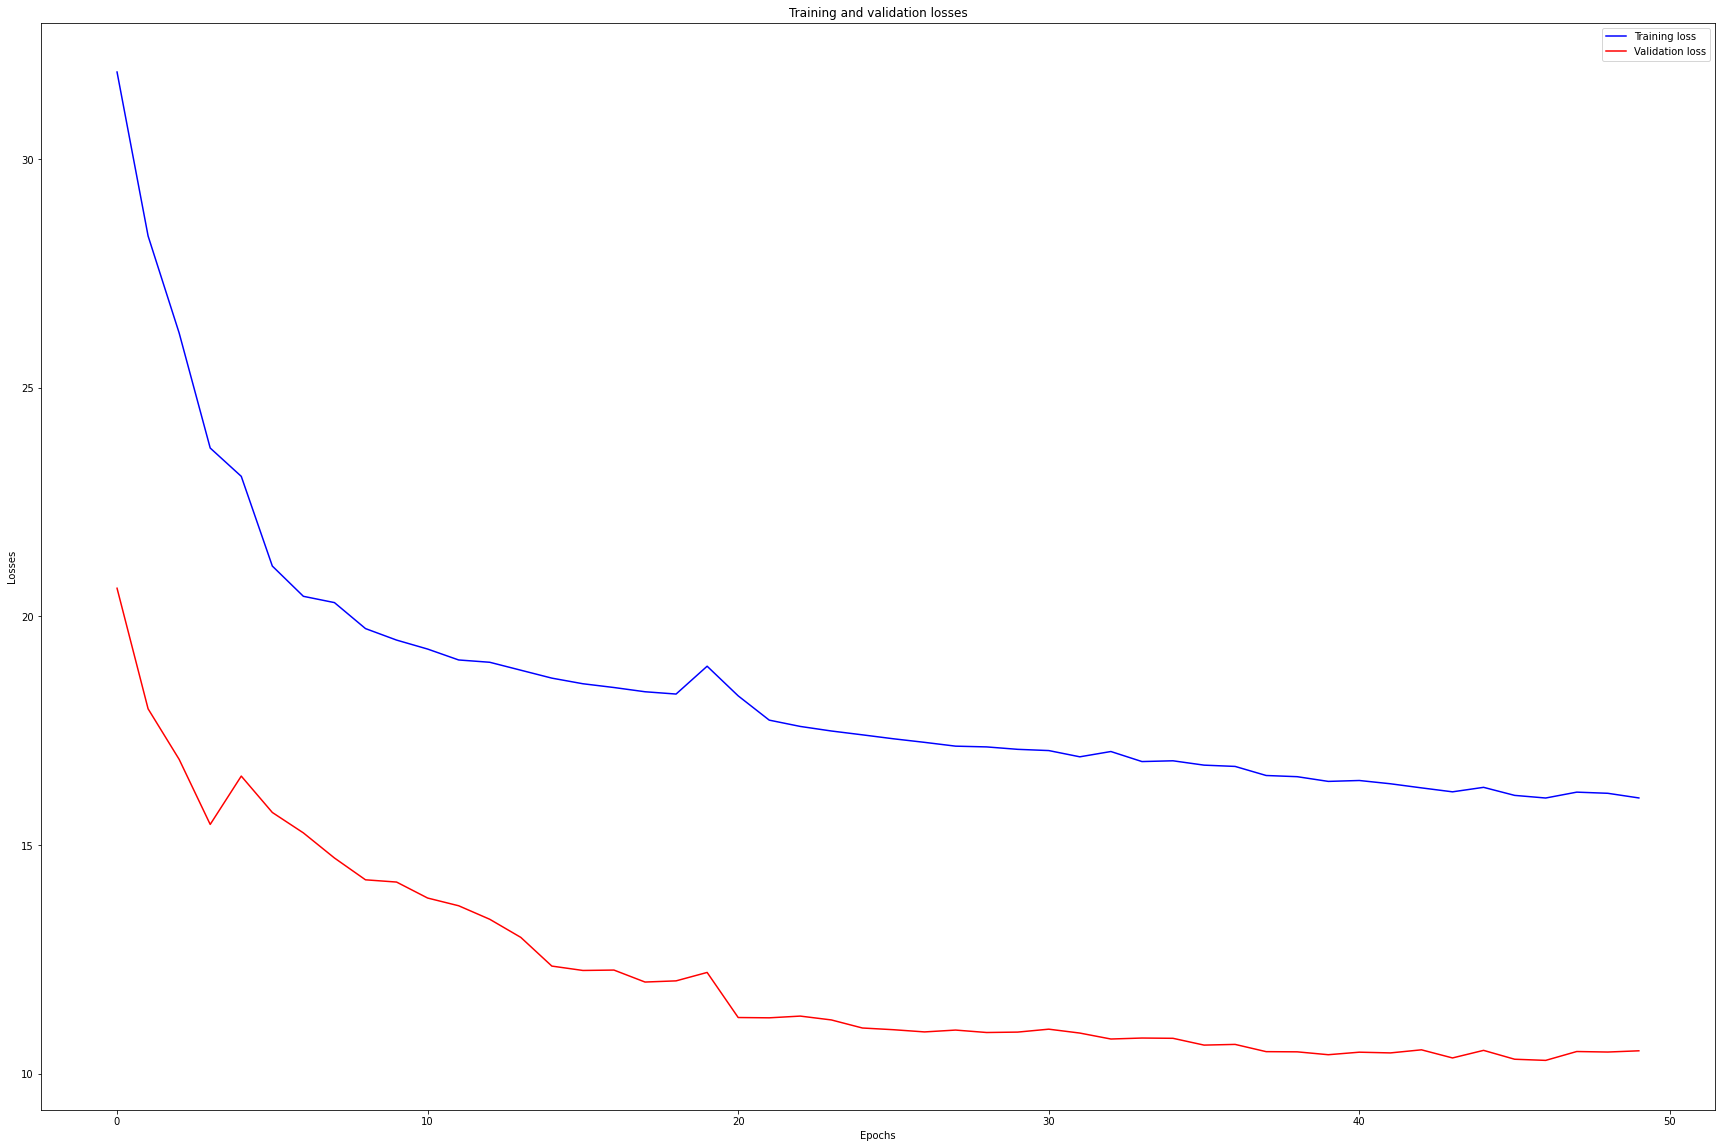

In [145]:
def plot_train_history(model):
    '''
    Convergence plots to have an idea on how the training performs
    '''
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']

    plt.figure()
    plt.plot(range(len(loss)), loss, 'b', label='Training loss')
    plt.plot(range(len(val_loss)), val_loss, 'r', label='Validation loss')
    #plt.yscale("log")
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Training and validation losses')
    plt.legend()
    plt.show()  
plot_train_history(model)

In [148]:
model_json = model.to_json()
with open("model_50_B!_cw.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_50_B1_cw.h5")

In [69]:
from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open("model_96_B!_nogaps_weather.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
deep_learner.model = model_from_json(loaded_model_json)
# load weights into new model
deep_learner.model.load_weights("model_96_B1_nogaps_weather.h5")
print("Loaded model from disk")

Loaded model from disk


(168946, 14, 1)


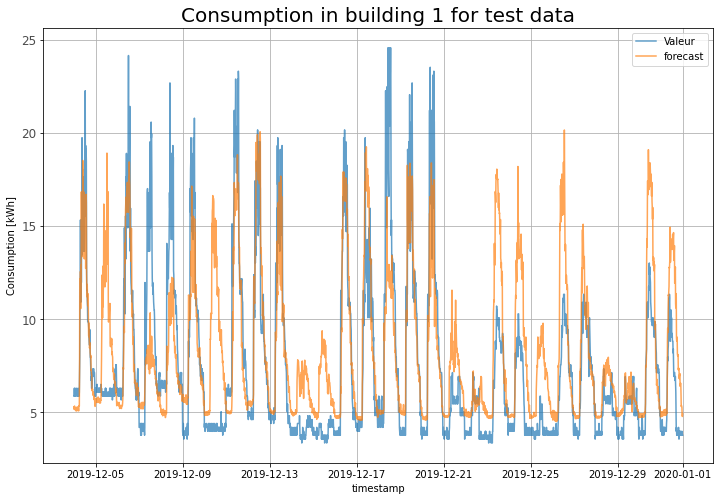

In [146]:
yhat = deep_learner.predict()# Constructing the forecast dataframe
#fc = holidata.nlargest(len(yhat),columns='Datetime').copy()
fc = holidata.tail(len(yhat)).copy()
fc['forecast'] = yhat
#fc['Datetime'] = pd.to_datetime(fc['Datetime'])
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['Valeur', 'forecast']:  
    plt.plot('Datetime',dtype,data=fc,label=dtype,alpha=0.7)
plt.legend()
plt.grid()

plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Consumption in building 1 for test data", fontsize=20)

plt.show()

In [ ]:
dates = pd.date_range(holidata.index[-1], periods=168, freq='15T')[1:]
test = holidata.append(pd.DataFrame(index=dates))

In [108]:
n_ahead = 168
testbit = test.tail(n_ahead).copy()
testbit['forecast'] = y_ahead
# Forecasting n steps ahead
y_ahead = deep_learner.predict_n_ahead(n_ahead)
y_ahead = [y[0][0] for y in y_ahead]
testbit['Valuer'] = y_ahead
testbit.index = pd.to_datetime(testbit.index)

(1, 96, 1)


In [109]:
testbit.tail(10)

,Valeur,working day,Temperatures (°C),Radiation (Wh/m²),Wind speed (m/s),hour of day,day of week,month,minutes,hour of day_sin,hour of day_cos,day of week_sin,day of week_cos,month_sin,month_cos,minutes_sin,minutes_cos,Datetime,forecast,Valuer
2020-01-02 15:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1.330188e+10,1.330188e+10
2020-01-02 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1.263517e+10,1.263517e+10
2020-01-02 15:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,6.473174e+09,6.473174e+09
2020-01-02 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,7.337847e+09,7.337847e+09
2020-01-02 16:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1.635749e+10,1.635749e+10
2020-01-02 16:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4.012451e+10,4.012451e+10
2020-01-02 16:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,3.113873e+10,3.113873e+10
2020-01-02 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,-2.334528e+09,-2.334528e+09
2020-01-02 17:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1.069298e+10,1.069298e+10
2020-01-02 17:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2.005720e+10,2.005720e+10


In [105]:
y_ahead

[1140.0013,
 4358.639,
 3534.1338,
 19631.014,
 7290.4995,
 8097.4976,
 6958.3735,
 5037.8975,
 2901.9028,
 5468.596,
 9287.933,
 4648.0664,
 19815.074,
 15413.923,
 15923.222,
 17664.812,
 5158.7505,
 4916.32,
 6605.747,
 15324.729,
 19473.76,
 10493.764,
 33634.895,
 25157.248,
 5508.709,
 9827.181,
 22885.334,
 10839.966,
 21688.209,
 19963.7,
 37534.707,
 86910.445,
 24248.096,
 19426.873,
 16085.24,
 25923.201,
 66003.69,
 76768.164,
 65385.582,
 74428.63,
 159430.92,
 634531.2,
 112486.47,
 66928.86,
 142761.45,
 183450.19,
 217103.61,
 364323.56,
 616454.7,
 371347.03,
 161850.02,
 95443.0,
 1640488.0,
 854663.94,
 463268.22,
 351625.03,
 493466.53,
 1347757.9,
 1782973.9,
 946647.7,
 699249.44,
 674629.5,
 900232.4,
 288443.44,
 1695547.0,
 3303644.8,
 3553398.2,
 3965674.2,
 1638324.0,
 2164734.8,
 3534758.8,
 3566498.2,
 6641693.0,
 4784584.0,
 11338056.0,
 7711062.0,
 4376413.0,
 4545864.0,
 9321586.0,
 31320590.0,
 8917146.0,
 4721227.5,
 5884381.5,
 7774902.5,
 10406540.0,

No handles with labels found to put in legend.


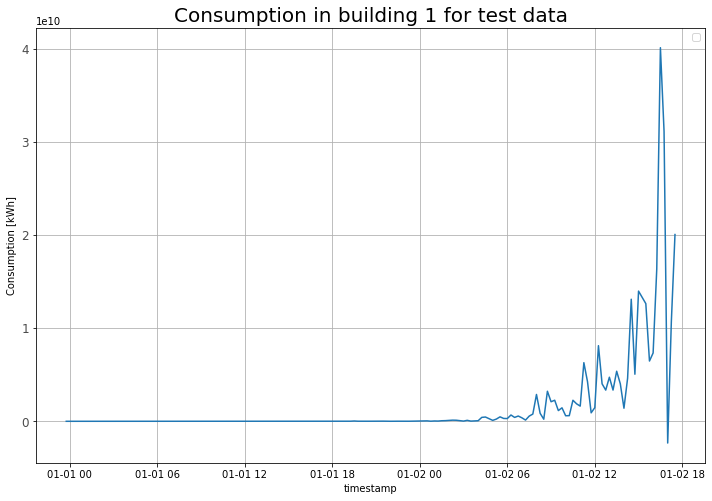

In [110]:
plt.figure(figsize=(12, 8)) 
plt.plot(testbit.index,y_ahead)
plt.legend()
plt.grid()

plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Consumption in building 1 for test data", fontsize=20)

plt.show()

In [21]:
fc = fc.set_index('Datetime', drop=False)
fc.index = pd.to_datetime(fc.index)
fc.head()

,Valeur,working day,Temperatures (°C),Radiation (Wh/m²),Wind speed (m/s),hour of day,day of week,month,minutes,hour of day_sin,hour of day_cos,day of week_sin,day of week_cos,month_sin,month_cos,minutes_sin,minutes_cos,Datetime,forecast
Datetime,,,,,,,,,,,,,,,,,,,
2019-03-29 08:30:00,11.76,True,8.009729,264.36526,0.545684,8,4,3,30,0.816970,-0.576680,-0.866025,-0.5,1.0,6.123234e-17,5.665539e-16,-1.000000e+00,2019-03-29 08:30:00,11.141492
2019-03-29 08:45:00,11.76,True,8.009729,264.36526,0.545684,8,4,3,45,0.816970,-0.576680,-0.866025,-0.5,1.0,6.123234e-17,-1.000000e+00,-1.836970e-16,2019-03-29 08:45:00,12.475636
2019-03-29 09:00:00,14.91,True,10.505426,411.88348,0.572128,9,4,3,0,0.631088,-0.775711,-0.866025,-0.5,1.0,6.123234e-17,0.000000e+00,1.000000e+00,2019-03-29 09:00:00,17.322645
2019-03-29 09:15:00,17.64,True,10.505426,411.88348,0.572128,9,4,3,15,0.631088,-0.775711,-0.866025,-0.5,1.0,6.123234e-17,1.000000e+00,2.832769e-16,2019-03-29 09:15:00,14.852518
2019-03-29 09:30:00,19.74,True,10.505426,411.88348,0.572128,9,4,3,30,0.631088,-0.775711,-0.866025,-0.5,1.0,6.123234e-17,5.665539e-16,-1.000000e+00,2019-03-29 09:30:00,13.318479


In [43]:
data_giles = pd.read_csv('forecasted_demand.csv')
data_giles['Date'] = pd.to_datetime(data_giles['Date'])
data_giles2 = pd.read_csv('forecasted_demand_w2.csv')
data_giles2['Date'] = pd.to_datetime(data_giles2['Date'])
data_giles

,Date,Forecasted consumption kW
0,2019-07-03 00:00:00,6.719238
1,2019-07-03 00:15:00,6.774531
2,2019-07-03 00:30:00,6.372161
3,2019-07-03 00:45:00,5.983380
4,2019-07-03 01:00:00,6.196634
...,...,...
667,2019-07-09 22:45:00,6.384984
668,2019-07-09 23:00:00,6.108797
669,2019-07-09 23:15:00,6.022966
670,2019-07-09 23:30:00,6.314056


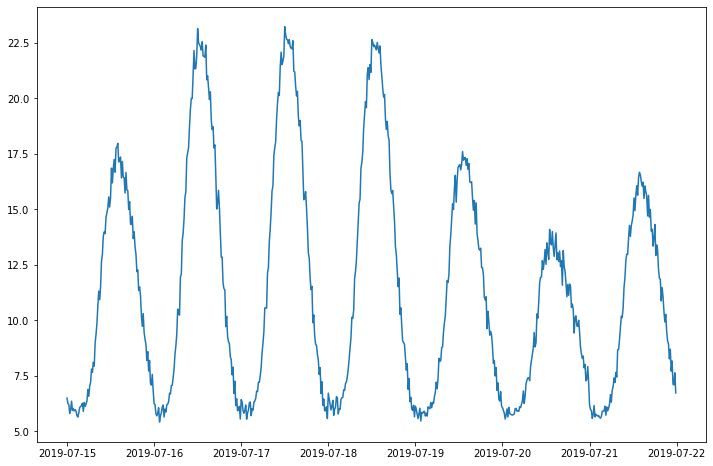

In [44]:
plt.figure(figsize=(12, 8))
plt.plot('Date',"Forecasted consumption kW",data=data_giles2)


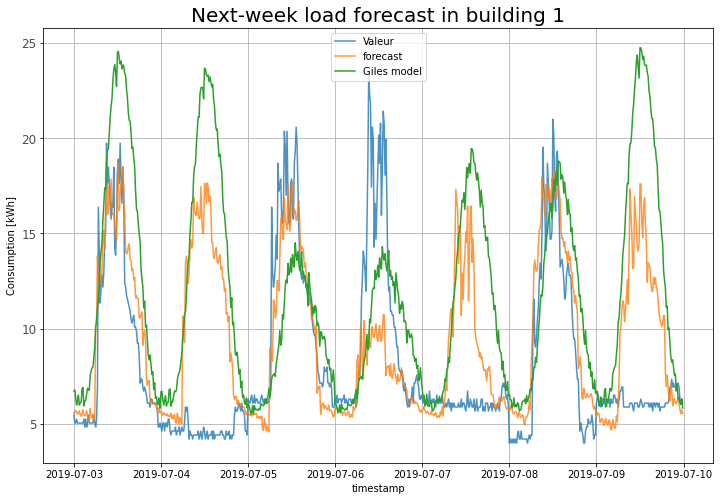

In [61]:
plt.figure(figsize=(12, 8))
for dtype in ['Valeur', 'forecast']:  
    #plt.plot('Datetime',dtype,data=fc['2019-07-15':'2019-07-21'],label=dtype,alpha=0.8)
    plt.plot('Datetime',dtype,data=fc['2019-07-03':'2019-07-09'],label=dtype,alpha=0.8)
    #plt.plot('Datetime',dtype,data=fc[:'2019'],label=dtype,alpha=0.8)
plt.plot('Date',"Forecasted consumption kW",data=data_giles, label='Giles model')
plt.legend()
plt.grid()

plt.rcParams.update({'figure.figsize': (30,20)})
plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Next-week load forecast in building 1", fontsize=20)

plt.show()

In [49]:
 def validation(forecasted, real, parameter):
        ''' 
        compute some important parameters to compare forecasting results
        '''
        value = 0
        value_1 = 0
        value_2 = 0
        
        if parameter == 'SMAPE':
            for i in range(len(forecasted)):
                if real[i] + forecasted[i] == 0:
                    value += 0
                else: 
                    value += ((abs(real[i] - forecasted[i])) / (real[i] + forecasted[i])) * 100
            final_value = value / len(forecasted)  
            
        elif parameter == 'MAPE':
            for i in range(len(forecasted)):
                if real[i] == 0:
                    value += 0
                else: 
                    value += (abs(real[i] - forecasted[i]))/real[i]
            final_value = value / len(forecasted) * 100
            
        elif parameter == 'RMSE':
            for i in range(len(forecasted)):
                value += (real[i] - forecasted[i]) ** 2
            final_value = (value / len(forecasted)) ** (1 / 2) 
            
        elif parameter == 'R':
            for i in range(len(forecasted)):
                value += (real[i] - np.mean(real)) * (forecasted[i] - np.mean(forecasted))
                value_1 += (real[i] - np.mean(real)) ** 2
                value_2 += (forecasted[i] - np.mean(forecasted)) ** 2
    
            if value_1 == 0 or value_2 == 0:
                final_value = 100
            else:
                final_value = (value / ((value_1 ** (1 / 2)) * (value_2 ** (1 / 2))))*100
            
        return final_value

In [65]:
#need to MAPE, RMSE and R-correlation factor
#expected = fc.loc['2019-07-03':'2019-07-09','Valeur']
expected = fc.loc['2019-07-15':'2019-07-21','Valeur']
#expected = fc.loc[:'2019','Valeur']
#predictions = fc.loc['2019-07-03':'2019-07-09','forecast']
predictions = fc.loc['2019-07-15':'2019-07-21','forecast']
#predictions = fc.loc[:'2019','forecast']
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]

In [67]:
print('RMSE: %f [kWh]' % validation(data_giles2["Forecasted consumption kW"],expected, 'RMSE'))
print('MAPE: %f %%' % validation(data_giles2["Forecasted consumption kW"],expected, 'MAPE'))


RMSE: 5.248523 [kWh]
MAPE: 70.529185 %


In [68]:
print('RMSE: %f [kWh]' % validation(predictions,expected, 'RMSE'))
print('MAPE: %f %%' % validation(predictions,expected, 'MAPE'))


RMSE: 2.350704 [kWh]
MAPE: 32.200698 %


In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print('RMSE: %f [kWh]' % rmse)

RMSE: 2.350704 [kWh]


In [52]:
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = check_array(y_true, y_pred)
    np.isfinite(expected).any()
    np.isfinite(predictions).any()
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(np.array(expected), np.array(predictions))
print('MAPE: %f %%' % mape)

MAPE: 32.200698 %


/home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Text(0, 0.5, 'MAPE %')]

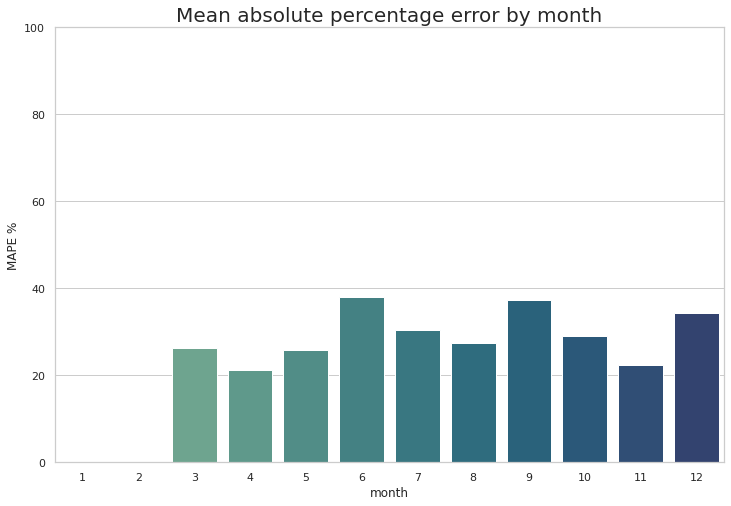

In [22]:
mape = []
for i in range(1,13):
    expected = fc['Valeur'].loc[fc.index.month == i]
    predictions = fc['forecast'].loc[fc.index.month == i]
    mape.append(mean_absolute_percentage_error(np.array(expected), np.array(predictions)))
data_tuples = list(zip(list(range(1,13)), mape))
months = pd.DataFrame(data_tuples, columns=['month','MAPE'])
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
#sns.color_palette('rocket', as_cmap=True)
ax = sns.barplot(x='month', y='MAPE', data = months, palette='crest')
ax.set_ylim([0,100])
plt.title("Mean absolute percentage error by month", fontsize=20)
ax.set(ylabel='MAPE %')

In [45]:
holidata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209826 entries, 2014-01-06 02:00:00 to 2020-07-01 00:00:00
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Datetime     209826 non-null  datetime64[ns]
 1   Valeur       209826 non-null  float64       
 2   working day  209826 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1)
memory usage: 5.0 MB


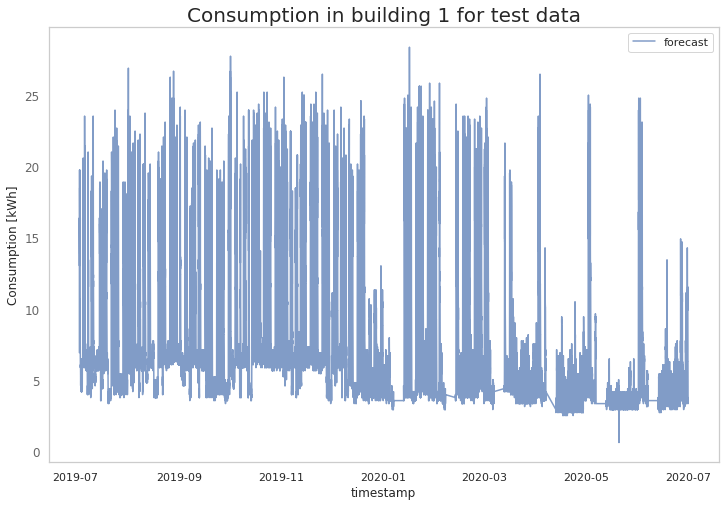

In [73]:
example = holidata.tail(len(yhat)).copy()
#example = holidata.nlargest(len(yhat),columns='Datetime').copy()
plt.figure(figsize=(12, 8))
plt.plot('Datetime','Valeur',data=example,label=dtype,alpha=0.7)
plt.legend()
plt.grid()

plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Consumption in building 1 for test data", fontsize=20)

plt.show()